In [1]:
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter

import utils.dlc_practical_prologue as prologue

from torchvision import transforms


%load_ext autoreload
%autoreload 2

In [2]:
def load_data(batch_size=20):
    transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
    )

    train_input, train_target, train_classes,\
        test_input, test_target, test_classes = prologue.generate_pair_sets(
            1000, transform=transform)

    trainset = TensorDataset(train_input, train_target, train_classes)
    testset = TensorDataset(test_input, test_target, test_classes)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers= 1)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers= 1)
    return trainloader, testloader

In [ ]:

BATCH_SIZE = 50

transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
)

train_input, train_target, train_classes,\
    test_input, test_target, test_classes = prologue.generate_pair_sets(
        1000, transform=transform)
    
# train_input = transform(train_input)
# test_input = transform(test_input)

trainset = TensorDataset(train_input, train_target, train_classes)
testset = TensorDataset(test_input, test_target, test_classes)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers= 1)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers= 1)

# target: 1 if digit 1 <= digit 2, 
#         0 otherwise


# Plotting the first 5 pairs of images
for i in range(1):
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(train_input[i, j].view(14, 14), cmap='gray')
        # plot the target and its class in the title
        plt.suptitle(f"Target: {train_target[i]}")
        plt.title(f' Class: {train_classes[i, j]}')
        plt.axis('off')
    plt.show()

# print the shapes of the tensors
print(f"Train input shape{train_input.shape}")
print(f"Train target shape{train_target.shape}")
print(f"Train classes shape{train_classes.shape}")
print('---')
print(f"Test input shape {test_input.shape}")
print(f"Test target shape {test_target.shape}")
print(f"Test classes shape {test_classes.shape}")


In [4]:
print(train_input[0,1].shape)
print(train_input[0,1].dtype)
print(train_input[0,1].max())
print(train_input[0,1].min())

torch.Size([14, 14])
torch.float32
tensor(0.9931)
tensor(0.)


### Baseline

In [5]:
print(torch.mean(train_target.float()))
print(torch.mean(test_target.float()))

tensor(0.5510)
tensor(0.5260)


In [6]:
baseline_target_pred = torch.ones_like(train_target)

# compute accuracy of the baseline and the test target
acc = 100 * (baseline_target_pred == test_target).sum().item() / test_target.shape[0]
print(f"Baseline accuracy: {acc:.2f}%")

Baseline accuracy: 52.60%


### Convolution Network with Auxiliary Loss

In [7]:
torch.cuda.is_available()

False

In [41]:
class Net(nn.Module):
   def __init__(self):
      super().__init__()
      
      self.conv1 = nn.Conv2d(1, 16, 3)
      self.pool1 = nn.MaxPool2d(2)
      self.conv2 = nn.Conv2d(16, 32, 3)
      self.conv3 = nn.Conv2d(32, 60, 3)
      
      self.fc1 = nn.Linear(60*2*2, 60)
      self.fc2 = nn.Linear(60, 30)
      
      # self.fc_target = nn.Linear(2, 1) # for target prediction
      
      self.fc_target1 = nn.Linear(20, 12) # for target prediction
      self.fc_target2 = nn.Linear(12, 1) 
      # self.fc_target3 = nn.Linear(8, 1) 
      
      self.fc_d = nn.Linear(30,10) # for auxilary loss
     
   def forward(self, data):
      x = torch.narrow(data,dim=1,start=0,length=1)
      y = torch.narrow(data,dim=1,start=1,length=1)
      
      
      x = self.pool1(F.relu(self.conv1(x)))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x) )
      x = x.view(x.size(0), -1)

      
      y = self.pool1(F.relu(self.conv1(y)))
      y = F.relu(self.conv2(y))
      y = F.relu(self.conv3(y))
      y = y.view(y.size(0), -1)
      
      emb_x = F.relu(self.fc_d(F.relu(self.fc2(F.relu(self.fc1(x))))))
      res_emb_x = torch.log_softmax(emb_x, dim = 1)
      
      emb_y = F.relu(self.fc_d(F.relu(self.fc2(F.relu(self.fc1(y))))))
      res_emb_y = torch.log_softmax(emb_y, dim = 1)
      
      
      # emb_x = torch.softmax(self.fc_d(emb_x), dim = 1).argmax().unsqueeze(0).type(torch.float)
      # cemb_y = torch.softmax(F.relu(self.fc_d(emb_y)), dim = 1).argmax().unsqueeze(0).type(torch.float)
      
      z = torch.cat((emb_x,emb_y),1)
      
      # 1. add fc layers to z
      z = F.relu(self.fc_target1(z))
      z = F.relu(self.fc_target2(z))
      res = torch.sigmoid(z)
      
      # z = torch.cat((x,y), 1)
      # z = F.relu(self.fc1(z))
      # z = F.relu(self.fc2(z))
      # emb_x = torch.softmax(F.relu(self.fc4(z)), dim = 1)
      # emb_y = torch.softmax(F.relu(self.fc4(z)), dim = 1)
      # res = torch.sigmoid(self.fc3(z))
      return res_emb_x, res_emb_y, res

In [9]:
class Net_bis(nn.Module):
   def __init__(self):
      super().__init__()
      
      self.conv1 = nn.Conv2d(1, 16, 3)
      self.pool1 = nn.MaxPool2d(2)
      self.conv2 = nn.Conv2d(16, 32, 3)
      self.conv3 = nn.Conv2d(32, 64, 3)
      
      self.fc1 = nn.Linear(64*2*2*2, 80)
      self.fc2 = nn.Linear(80, 40)
      
      self.fc3 = nn.Linear(40, 1) # for target prediction
      self.fc4 = nn.Linear(40,10) # for auxilary loss
      
      
      
   def forward(self, data):
      x = torch.narrow(data,dim=1,start=0,length=1)
      y = torch.narrow(data,dim=1,start=1,length=1)
      
      
      x = self.pool1(F.relu(self.conv1(x)))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x) )
      x = x.view(x.size(0), -1)

      
      y = self.pool1(F.relu(self.conv1(y)))
      y = F.relu(self.conv2(y))
      y = F.relu(self.conv3(y))
      y = y.view(y.size(0), -1)
      
      z = torch.cat((x,y), 1)
      
      z = F.relu(self.fc1(z))
      z = F.relu(self.fc2(z))
      res = torch.sigmoid(self.fc3(z))

      emb_x = torch.softmax(F.relu(self.fc4(z)), dim = 1)
      emb_y = torch.softmax(F.relu(self.fc4(z)), dim = 1)
      return emb_x, emb_y, res

In [17]:
tb = SummaryWriter('runs/aux_loss/graph')
model_view = Net()
trainloader, testloader = load_data()
images, labels,classes = next(iter(trainloader))
# grid = torchvision.utils.make_grid(images)
# tb.add_image("images", grid)
tb.add_graph(model_view, images)
tb.close()

In [11]:
def test_accuracy(net, testloader):

    acc = 0
    for i, data in enumerate(testloader, 0):
        
        inputs, labels, classes = data

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels, classes = inputs.to(device), labels.to(device), classes.to(device)
    
        _,_,output_z = net(inputs)
        equality = (labels.reshape(-1, 1) == output_z.round().to(torch.int))
        acc += equality.to(torch.float).mean()

    return acc.item() / (i+1)

# acc = test_accuracy(net, testloader)
# print(f'Accuracy of the network on the {(i+1)*testloader.batch_size} test images: {100*acc:.1f} %')

In [15]:

# net = Net()

def train_model(model, trainloader,testloader, num_epochs=25,tb_dir=None):
        
    criterion = nn.BCELoss()
    aux_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    tb = SummaryWriter(tb_dir)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels,classes = data

            inputs, labels, classes = inputs.to(device), labels.to(device), classes.to(device)
            
            # optimizer.zero_grad()   # zero the gradient buffers
            
            # Pytorch: The second code snippet does not zero the memory of each individual parameter,
            # also the subsequent backward pass uses assignment instead of addition to store gradients,
            # this reduces the number of memory operations.
            for param in model.parameters():
                param.grad = None
            
            
            output_x,output_y,output_z = model(inputs)
                    
                                
            # TODO : COMPUTE LOSS
          
            loss_x = aux_criterion(output_x, classes[:,0])
            loss_y = aux_criterion(output_y, classes[:,1])

            loss_z = criterion(output_z, labels.reshape(-1,1).type_as(output_z[:,:10]))
            loss = 0.2*loss_x + 0.2*loss_y + 0.6*loss_z
            
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 2000 mini-batches
                print('[%d / %d, %5d] loss: %.3f' % 
                    (epoch + 1,num_epochs, i + 1, running_loss / (1000/trainloader.batch_size)), end='\r')
                running_loss = 0.0
        
        train_acc = test_accuracy(model, trainloader)
        test_acc = test_accuracy(model, testloader)
        
        tb.add_scalar("Loss", loss, epoch)
        # tb.add_scalar("Accuracy", train_acc, epoch, "train")
        # tb.add_scalar("Accuracy", test_acc, epoch, "test")
        
        tb.add_scalars("Accuracy", {"train": train_acc, "test": test_acc}, epoch)

        tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
        tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
        tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
        tb.add_histogram("conv2.weight", model.conv2.weight, epoch)
        
        tb.add_histogram("fc1.bias", model.fc1.bias, epoch)
        tb.add_histogram("fc1.weight", model.fc1.weight, epoch)
        tb.add_histogram("fc2.bias", model.fc2.bias, epoch)
        tb.add_histogram("fc2.weight", model.fc2.weight, epoch)
        
        tb.add_histogram("fc_d.bias", model.fc_d.bias, epoch)
        tb.add_histogram("fc_d.weight", model.fc_d.weight, epoch)
        
        tb.add_histogram("fc_target1.weight", model.fc_target1.weight, epoch)
        tb.add_histogram("fc_target1.bias", model.fc_target1.bias, epoch)
        tb.add_histogram("fc_target2.weight", model.fc_target2.weight, epoch)
        tb.add_histogram("fc_target2.bias", model.fc_target2.bias, epoch)
        # tb.add_histogram("fc_target3.weight", model.fc_target3.weight, epoch)
        # tb.add_histogram("fc_target3.bias", model.fc_target3.bias, epoch)
        
    tb.close()
            

In [ ]:
# test model 10 times and save accuracies for mean and std
accuracies = []
ROUNDS = 10
for i in range(ROUNDS):
    # load data
    trainloader, testloader = load_data(batch_size=20)
    net = Net()
    train_model(net, trainloader,testloader, num_epochs=25, tb_dir=f'./runs/aux_loss/run_{i+1}')
    acc = test_accuracy(net, testloader)
    accuracies.append(acc*100)
    print(f'\n Accuracies [%]: [{", ".join([f"{acc:.3f}" for acc in accuracies])}]')

Mean accuracy of the network on the 1000 test images:     83.5 % (+/- 8.8 %)


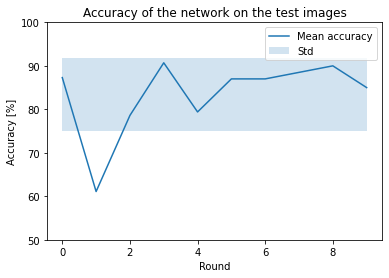

In [50]:
print(f'Mean accuracy of the network on the {len(testloader.dataset)} test images: \
    {torch.mean(torch.tensor(accuracies)):.1f} % (+/- {torch.std(torch.tensor(accuracies)):.1f} %)')

mean = np.mean(accuracies)
std = np.std(accuracies)
# plot accuracies and fill_between std
plt.figure()
plt.plot(accuracies)
plt.fill_between(range(len(accuracies)), mean-std, mean+std, alpha=0.2)
plt.legend([f'Mean: {mean:.3f} %', f'Std: {std:.3f} %'])
plt.xlabel('Round')
plt.ylabel('Accuracy [%]')
plt.ylim([50,100])
plt.title('Accuracy of the network on the test images')
plt.legend(['Mean accuracy', 'Std'])



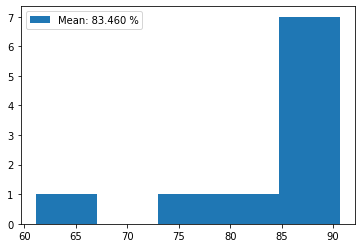

In [52]:
mean = np.mean(accuracies)
std = np.std(accuracies)

plt.hist(accuracies, bins='auto')
# plt.fill_between(range(len(accuracies)), mean-std, mean+std, alpha=0.2)
plt.legend([f'Mean: {mean:.3f} %', f'Std: {std:.3f} %'])

In [53]:
from torchsummary import summary
model_view = Net()
summary(model_view,(2,14,14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         MaxPool2d-2             [-1, 16, 6, 6]               0
            Conv2d-3             [-1, 32, 4, 4]           4,640
            Conv2d-4             [-1, 60, 2, 2]          17,340
            Conv2d-5           [-1, 16, 12, 12]             160
         MaxPool2d-6             [-1, 16, 6, 6]               0
            Conv2d-7             [-1, 32, 4, 4]           4,640
            Conv2d-8             [-1, 60, 2, 2]          17,340
            Linear-9                   [-1, 60]          14,460
           Linear-10                   [-1, 30]           1,830
           Linear-11                   [-1, 10]             310
           Linear-12                   [-1, 60]          14,460
           Linear-13                   [-1, 30]           1,830
           Linear-14                   

### model saving

In [54]:
# save model parameters
torch.save(net.state_dict(), './Models/cnn_aux_loss.pt')

In [55]:
# load model parameters
model1 = Net()
model1.load_state_dict(torch.load('./Models/cnn_aux_loss.pt'))
model1.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 60, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=240, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc_target1): Linear(in_features=20, out_features=12, bias=True)
  (fc_target2): Linear(in_features=12, out_features=1, bias=True)
  (fc_d): Linear(in_features=30, out_features=10, bias=True)
)